In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [6]:
#get table names using inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
#Declare a Base using 'automap_base()'
Base = automap_base()
#Use the Base  class to reflect teh database tables
Base.prepare(engine, reflect=True)

In [8]:
#used another method to check the dataframes
#measurement = pd.read_sql("SELECT * FROM measurement", conn)
#station = pd.read_sql("SELECT * FROM station", conn)

In [9]:
#measurement.head()

In [10]:
#station.head()

In [11]:
# We can view all of the classes that automap found
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

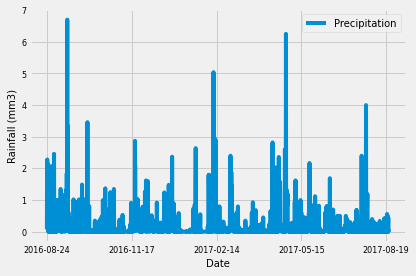

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain, columns=['Date', 'Precipitation'])
rain_df.set_index('Date', inplace=True)
rain_df = rain_df.dropna()

# Sort the dataframe by date
rain_df = rain_df.sort_values(by=['Date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = rain_df.plot()

ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Rainfall (mm3)", fontsize=10)
ax.legend(loc="upper right", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig("Rainfall.png")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Station)
print(station.count())

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active = active_stations[0][0]
print(f"The most active station was {most_active}")

The most active station was USC00519281


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
calculate = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active).all()
print(f"Low : {calculate[0][0]}")
print(f"High : {calculate[0][1]}")
print(f"Average : {calculate[0][2]}")

Low : 54.0
High : 85.0
Average : 71.66378066378067


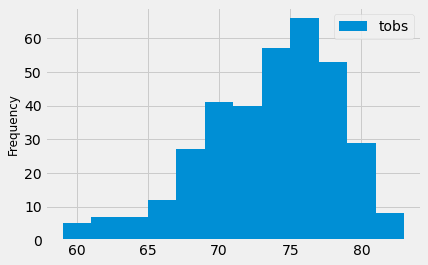

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
order_by(Measurement.tobs).\
filter(Measurement.date <= "2017-08-24").\
filter(Measurement.date >= "2016-08-23").\
filter(Measurement.station==most_active).all()
x = list(np.ravel(results))

results_df = pd.DataFrame(data=results, columns=["date", "tobs"])
results_df = results_df.set_index('date', drop=True)

plt.hist(results_df['tobs'],12, label="tobs")
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.savefig("Temperature_active station_12months.png")
plt.show()

## Bonus: Other Recommended Analyses

### Temperature Analysis I


* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?


* You may either use SQLAlchemy or pandas's read_csv() to perform this portion.


* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.


* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [21]:
june_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert raw data to DataFrames to label them and then concatenate into one DataFrame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
december_df = pd.DataFrame(december_data,columns=["Date","Temperature"])
june_df["Month"] = "June"
december_df["Month"] = "December"
temp_df = pd.concat([june_df,december_df], ignore_index=True)

# calculate the average for both June and December
avg_temp_month = temp_df.groupby("Month").mean()
avg_temp_month

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

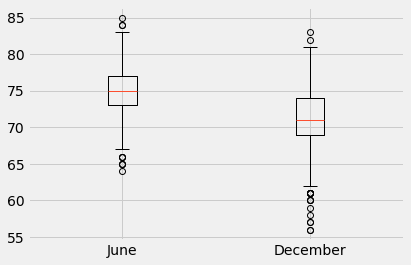

In [22]:
box_data = [june_df["Temperature"],december_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_df["Temperature"], december_df["Temperature"])

Average temperature for June for all stations is 74.94 degrees
Average temperature for December for all stations is 71.04 degrees
P-value less than 0.05 means that the null hypothesis can be rejected and there is a statistically significant difference between temperatures in June compared to December.
Box plot was done to view visually.

### Temperature Analysis II


* The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.

* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

    * Use the average temperature as the bar height.

    * Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2018-01-01'))

[('2017-05-23', 58.0, 74.14387974230493, 87.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Let's choose the date range 28/02/2018-05/03/2018.
trip_start = dt.date(2018, 2, 28)
trip_end = dt.date(2018, 3, 5)
last_year = dt.timedelta(days=365)

trip_summary = calc_temps((trip_start-last_year), (trip_end-last_year))

print(trip_summary)

[('2017-03-03', 64.0, 72.02777777777777, 78.0)]


(0.0, 100.0)

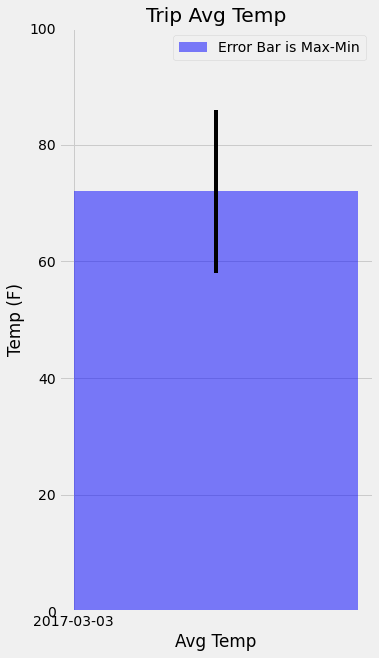

In [94]:
# Plot the results from your previous query as a bar chart. 
bar_trip_df = pd.DataFrame(data=trip_summary, columns=["date","tmin", "tavg", "tmax"])
bar_trip_df = bar_trip_df.set_index('date', drop=True)
plot_date = bar_trip_df.index.values
plot_tmin = bar_trip_df['tmin']
plot_tavg = bar_trip_df['tavg']
plot_tmax = bar_trip_df['tmax']
min_max_diff = bar_trip_df['tmax'] - bar_trip_df['tmin']
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)



plt.figure(figsize=(5,10))
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.bar(plot_date,height=plot_tavg, yerr=min_max_diff, color='b',alpha=.5,align='edge',label="Error Bar is Max-Min")
plt.legend()
plt.ylim(0,100)



### Daily Rainfall Average


* Calculate the rainfall per weather station using the previous year's matching dates.


* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.


In [96]:
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

## Daily Temperature Normals


* You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.


* Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.


* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.


* Use Pandas to plot an area plot (stacked=False) for the daily normals.

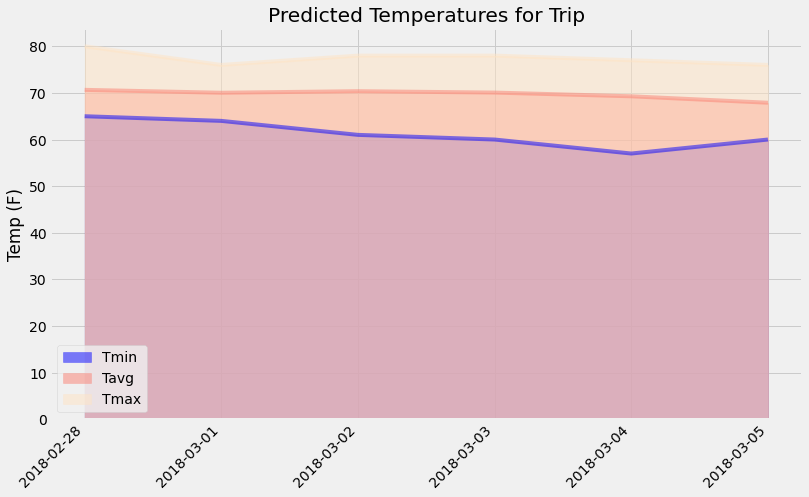

In [99]:
# create a list of dates for your trip 
trip_dates = pd.date_range(trip_start, trip_end)

# format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

# calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    # call daily_normals function to return the tuple list
    normals_list.append(*daily_normals(trip_date))

# make a normal df from the normals list
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
# make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

# Now plot the results 
# the colors list
colors = ['blue', 'salmon', 'bisque']

normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, title='Predicted Temperatures for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig("Predicted_Temp_Trip.png")
plt.show()